In [11]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.inspection import permutation_importance

# XGBoost
import xgboost as xgb

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns



Churn Rate: 20.369999999999997

Correlations with Churn:
Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64

Geographic Distribution of Churn:
Geography
France     16.154767
Germany    32.443204
Spain      16.673395
Name: Exited, dtype: float64

Gender Distribution of Churn:
Gender
Female    25.071539
Male      16.455928
Name: Exited, dtype: float64

Results for Random Forest:
Accuracy: 0.8570
ROC-AUC: 0.8506

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.75      0.45      0.56       407

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000


Resul

C:\Users\thepa\AppData\Local\Temp\ipykernel_37432\293054827.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_churn = data.groupby(age_groups)['Exited'].mean()


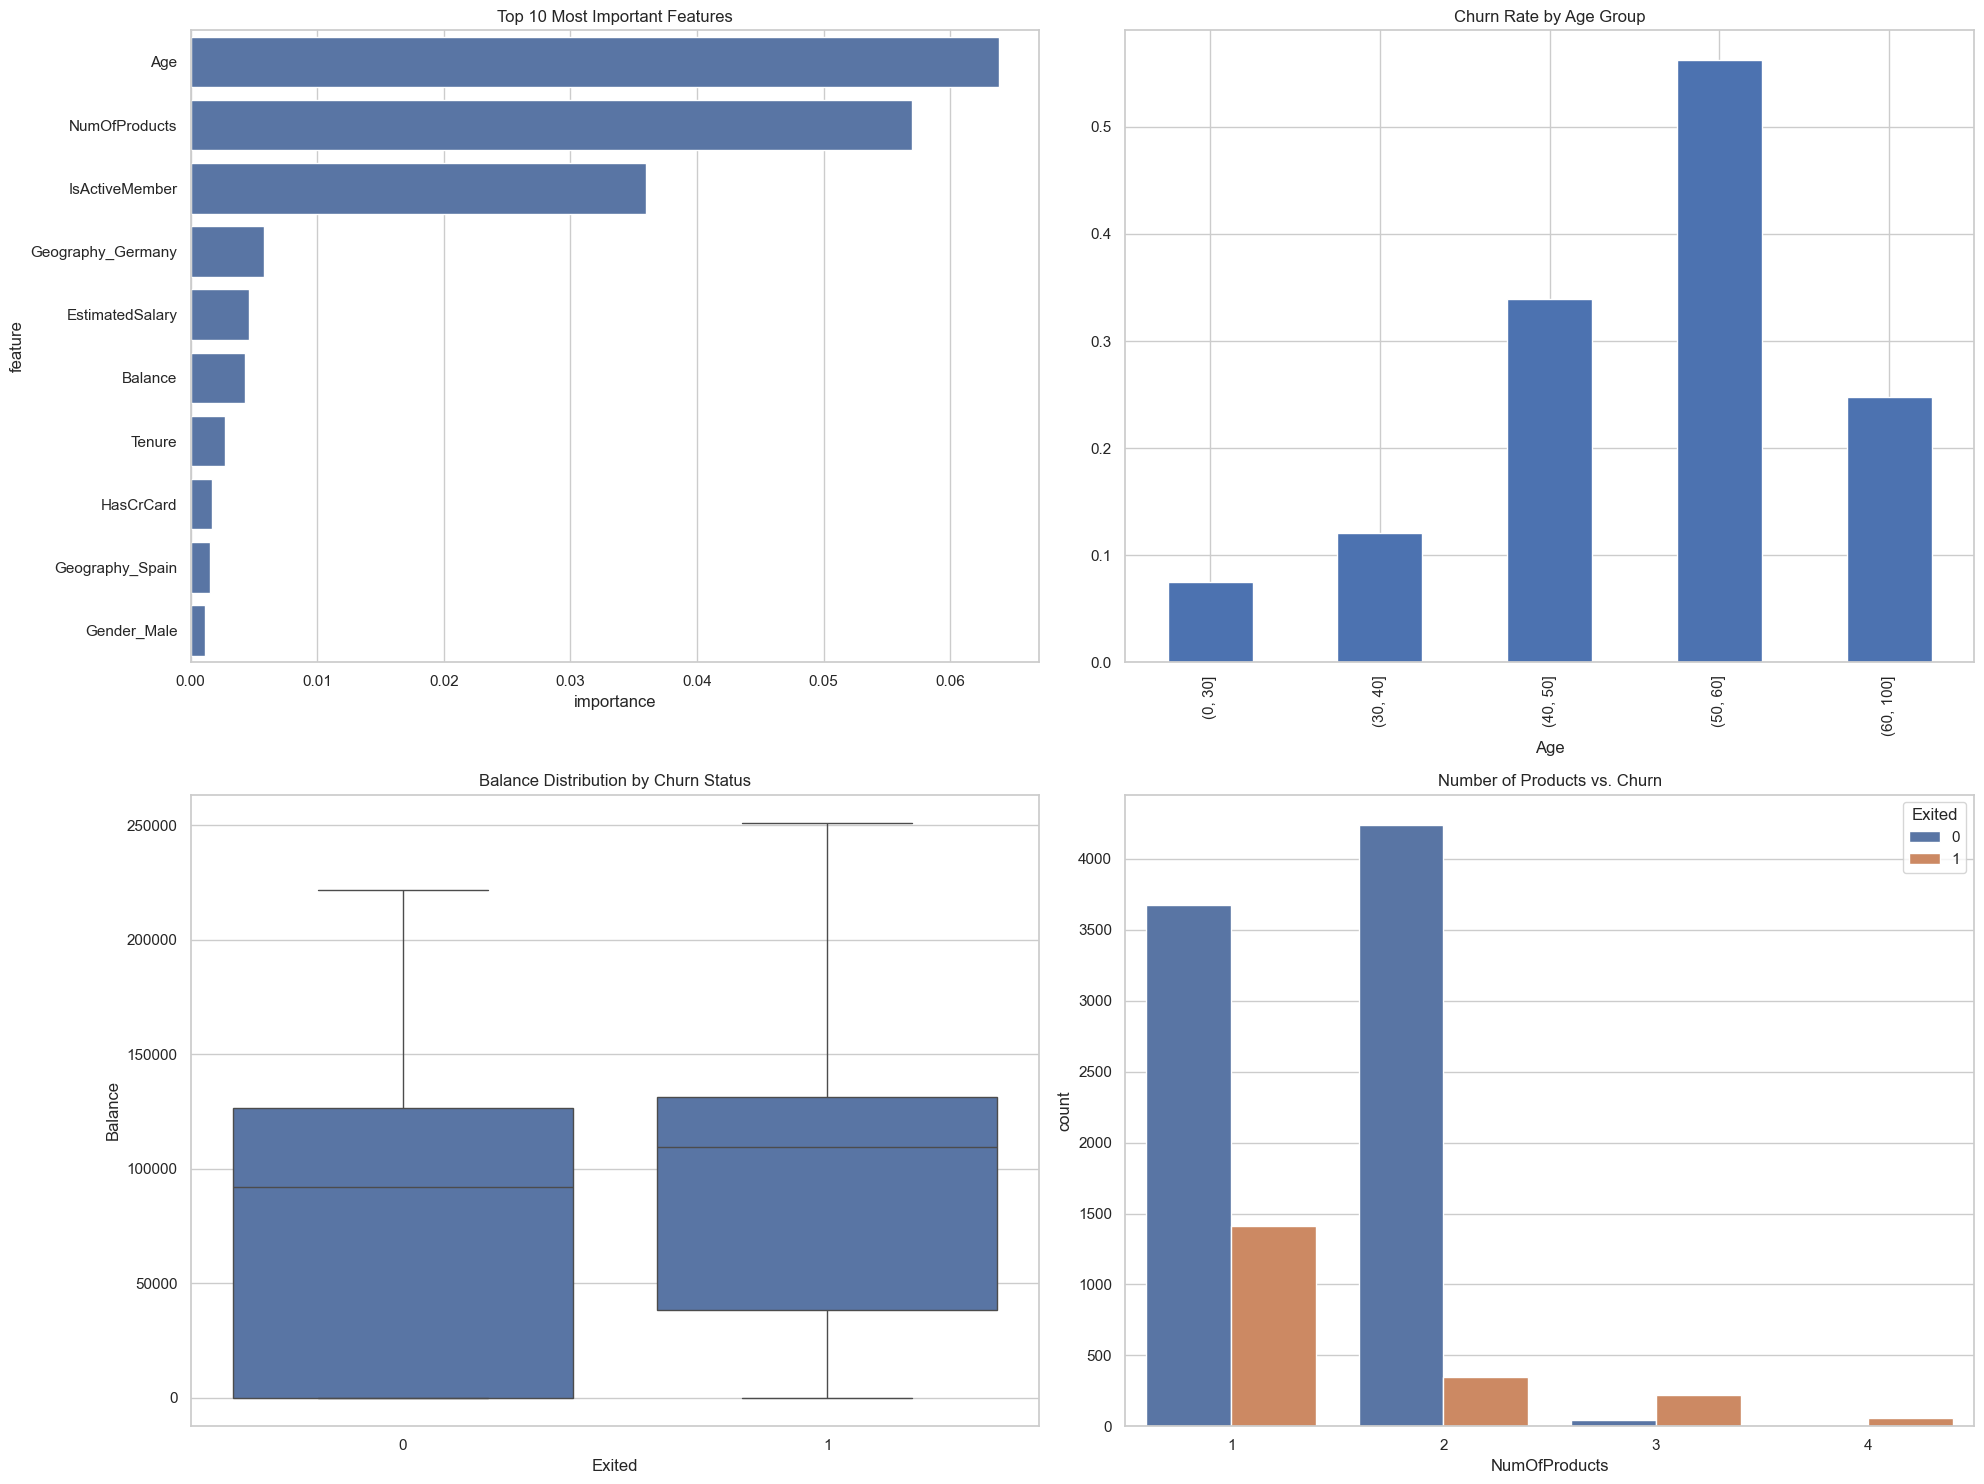

In [16]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the bank customer data using One-Hot Encoding
    """
    # Load data
    data = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
    
    # Separate features for one-hot encoding
    categorical_features = ['Gender', 'Geography']
    numerical_features = [col for col in data.columns if col not in categorical_features + ['Exited']]
    
    # Create a copy of original data for initial analysis
    data_original = data.copy()
    
    # Apply one-hot encoding
    data_encoded = pd.get_dummies(data[categorical_features], prefix=categorical_features)
    
    # Combine with numerical features
    X = pd.concat([data[numerical_features], data_encoded], axis=1)
    y = data['Exited']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale the numerical features
    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(X_train[numerical_features])
    X_train_scaled = pd.DataFrame(numerical_scaled, columns=numerical_features)
    
    numerical_scaled_test = scaler.transform(X_test[numerical_features])
    X_test_scaled = pd.DataFrame(numerical_scaled_test, columns=numerical_features)
    
    # Add back the encoded categorical features
    categorical_columns = data_encoded.columns
    X_train_scaled = pd.concat([
        X_train_scaled, 
        X_train[categorical_columns].reset_index(drop=True)
    ], axis=1)
    
    X_test_scaled = pd.concat([
        X_test_scaled, 
        X_test[categorical_columns].reset_index(drop=True)
    ], axis=1)
    
    return data_original, X_train_scaled, X_test_scaled, y_train, y_test, scaler, X_train_scaled.columns

def analyze_initial_data(data):
    """
    Perform initial exploratory data analysis
    """
    # Identificar columnas numéricas para correlaciones
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    
    analysis = {
        'basic_stats': data.describe(),
        'churn_rate': data['Exited'].mean() * 100,
        'correlations': data[numerical_columns].corr()['Exited'].sort_values(ascending=False),
        'geographic_distribution': data.groupby('Geography')['Exited'].mean() * 100,
        'gender_distribution': data.groupby('Gender')['Exited'].mean() * 100,
        'age_distribution': {
            'mean_age': data['Age'].mean(),
            'age_groups': pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100]).value_counts()
        }
    }
    return analysis

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple models
    """
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(random_state=42, probability=True),
        'XGBoost': xgb.XGBClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    
    results = {}
    best_model = None
    best_accuracy = 0
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    return results, best_model

def analyze_feature_importance(best_model, X_test, y_test, feature_names):
    """
    Analyze feature importance using the best model
    """
    if isinstance(best_model, (RandomForestClassifier, DecisionTreeClassifier, xgb.XGBClassifier)):
        importance = best_model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
    else:
        result = permutation_importance(
            best_model, X_test, y_test, n_repeats=10, random_state=42
        )
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': result.importances_mean
        }).sort_values('importance', ascending=False)
    
    return feature_importance

def plot_insights(data, feature_importance):
    """
    Create visualizations for key insights
    """
    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Feature Importance
    plt.subplot(2, 2, 1)
    sns.barplot(
        data=feature_importance.head(10),
        x='importance',
        y='feature'
    )
    plt.title('Top 10 Most Important Features')
    
    # 2. Age vs. Churn Rate
    plt.subplot(2, 2, 2)
    age_groups = pd.cut(data['Age'], bins=[0, 30, 40, 50, 60, 100])
    age_churn = data.groupby(age_groups)['Exited'].mean()
    age_churn.plot(kind='bar')
    plt.title('Churn Rate by Age Group')
    
    # 3. Balance vs. Churn
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Exited', y='Balance', data=data)
    plt.title('Balance Distribution by Churn Status')
    
    # 4. Products vs. Churn
    plt.subplot(2, 2, 4)
    sns.countplot(data=data, x='NumOfProducts', hue='Exited')
    plt.title('Number of Products vs. Churn')
    
    plt.tight_layout()
    return fig

# Example usage:
if __name__ == "__main__":
    # Load and preprocess data
    data, X_train, X_test, y_train, y_test, scaler, feature_names = load_and_preprocess_data('Churn_Modelling.csv')

    # Perform initial analysis
    initial_analysis = analyze_initial_data(data)
    print("Churn Rate:", initial_analysis['churn_rate'])
    print("\nCorrelations with Churn:")
    print(initial_analysis['correlations'])
    print("\nGeographic Distribution of Churn:")
    print(initial_analysis['geographic_distribution'])
    print("\nGender Distribution of Churn:")
    print(initial_analysis['gender_distribution'])

    # Train and evaluate models
    results, best_model = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Print results for each model
    for model_name, result in results.items():
        print(f"\nResults for {model_name}:")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"ROC-AUC: {result['roc_auc']:.4f}")
        print("\nClassification Report:")
        print(result['classification_report'])

    # Analyze feature importance
    feature_importance = analyze_feature_importance(best_model, X_test, y_test, feature_names)
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head())

    # Create and display visualizations
    plot_insights(data, feature_importance)
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

def add_kmeans_risk_with_probability(filepath):
    # Cargar datos
    data = pd.read_csv(filepath)
    
    # Preparar datos
    data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
    X = data.drop('Exited', axis=1)
    y = data['Exited']
    
    # Definir columnas categóricas y numéricas
    categorical_features = ['Gender', 'Geography']
    numerical_features = [col for col in X.columns if col not in categorical_features]
    
    # Transformación de datos
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first'))
    ])
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Preprocesar datos
    X_transformed = preprocessor.fit_transform(X)
    
    # Aplicar KMeans para clasificar niveles de riesgo
    kmeans = KMeans(n_clusters=3, random_state=42)
    data['Cluster'] = kmeans.fit_predict(X_transformed)
    
    # Calcular la probabilidad de que cada cluster tenga Exited=1
    cluster_exited_prob = data.groupby('Cluster')['Exited'].mean().to_dict()
    data['Exited_Probability'] = data['Cluster'].map(cluster_exited_prob)
    
    # Mapear cada cluster a la categoría de Exited más frecuente
    cluster_to_exited = data.groupby('Cluster')['Exited'].agg(lambda x: x.value_counts().index[0]).to_dict()
    data['Cluster_Prediction'] = data['Cluster'].map(cluster_to_exited)
    
    # Calcular accuracy al comparar Cluster_Prediction con Exited
    accuracy = accuracy_score(y, data['Cluster_Prediction'])
    
    # Mapear niveles de riesgo a los clusters
    risk_mapping = {0: 'low', 1: 'medium', 2: 'high'}
    data['Risk_Level'] = data['Cluster'].map(risk_mapping)
    
    # Crear un nuevo DataFrame con las columnas originales y la columna Risk_Level
    data_with_risk_level = data.drop(columns=['Cluster', 'Cluster_Prediction', 'Exited_Probability']).copy()

    # Imprimir la tabla con solo las columnas solicitadas
    print("Data with Risk Level, Cluster Prediction, and Exited Probability:")
    print(data[['Exited', 'Cluster', 'Cluster_Prediction', 'Risk_Level', 'Exited_Probability']].head())
    
    # Imprimir la tabla original con la columna Risk_Level concatenada
    print("\nOriginal Data with Risk_Level Column:")
    print(data_with_risk_level.head())

    return data_with_risk_level, accuracy

# Ejemplo de uso
data_with_risk_level, accuracy = add_kmeans_risk_with_probability('Churn_Modelling.csv')
print(f"\nAccuracy of KMeans clustering based on Exited: {accuracy:.2f}")


Data with Risk Level, Cluster Prediction, and Exited Probability:
   Exited  Cluster  Cluster_Prediction Risk_Level  Exited_Probability
0       1        2                   0       high            0.158541
1       0        1                   0     medium            0.240284
2       1        0                   0        low            0.181679
3       0        2                   0       high            0.158541
4       0        1                   0     medium            0.240284

Original Data with Risk_Level Column:
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMe

In [ ]:
data_with_risk_level

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Risk_Level
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,high
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,medium
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,low
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,high
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,high
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,medium
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,high
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,low


In [ ]:
# export data_with_risk_level into csv
data_with_risk_level.to_csv('data_with_risk_level.csv', index=False)

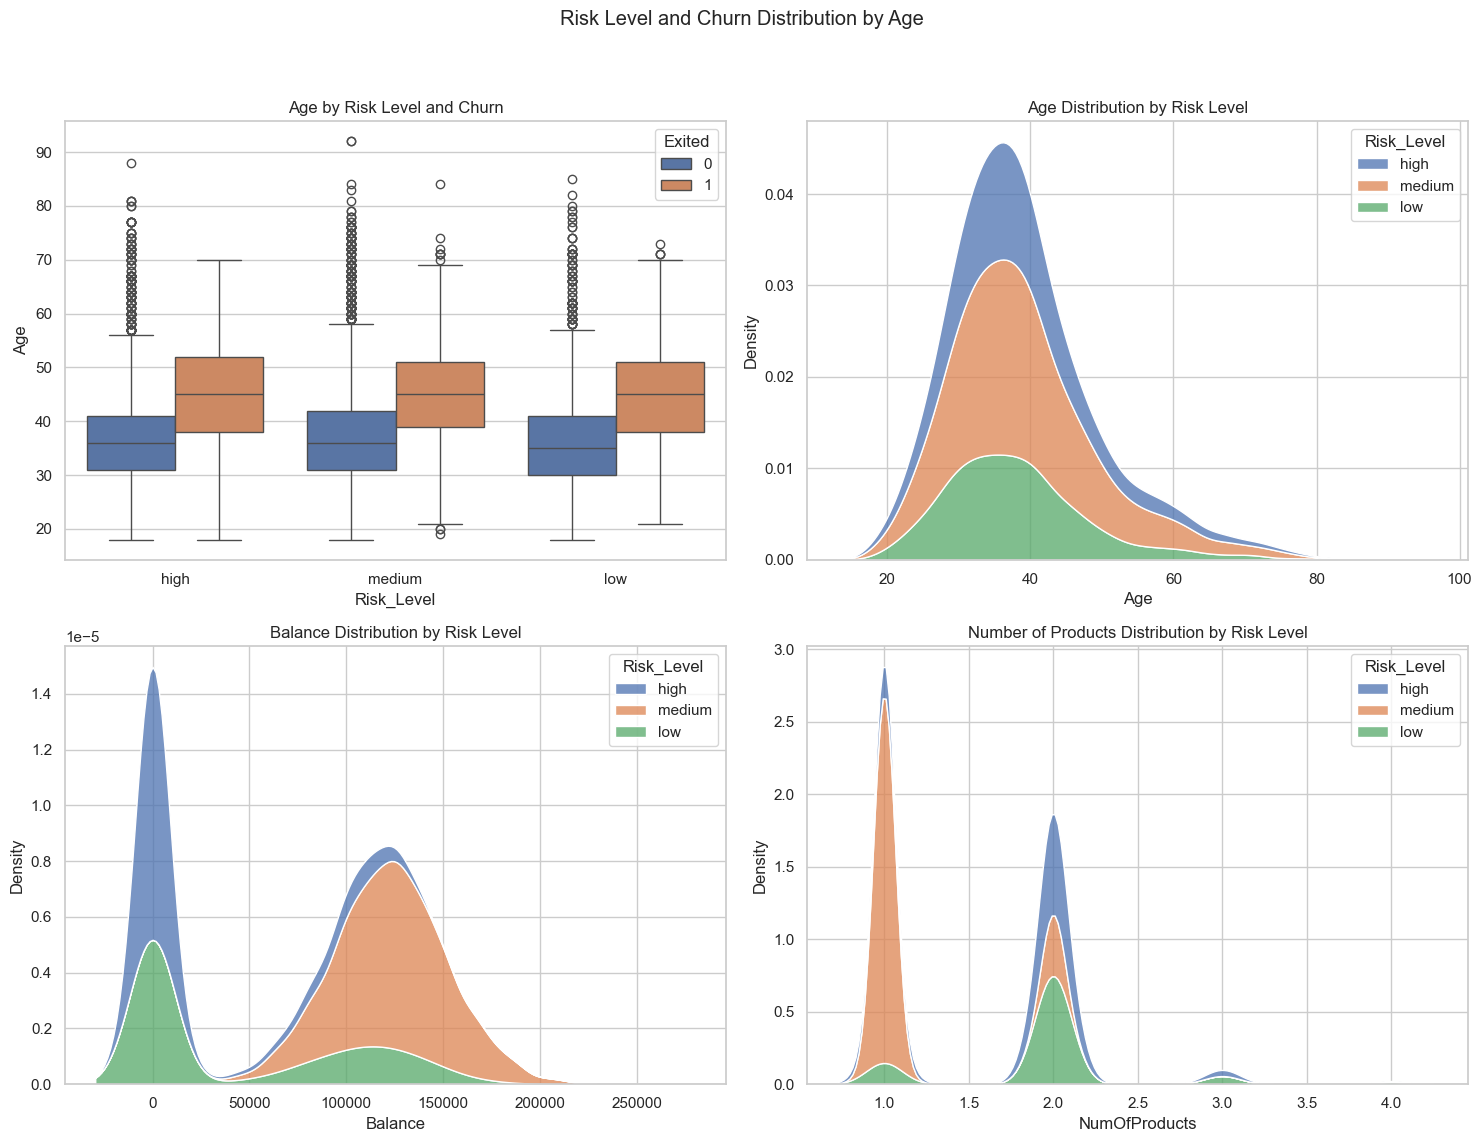

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = data_with_risk_level

# Set up the plotting environment
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Risk Level and Churn Distribution by Age")

# Age distribution by Risk Level and Churn
sns.boxplot(x="Risk_Level", y="Age", hue="Exited", data=data, ax=axes[0, 0])
axes[0, 0].set_title("Age by Risk Level and Churn")
axes[0, 0].legend(title="Exited", loc="upper right")

# KDE plots for Age, Balance, and Number of Products by Risk Level
sns.kdeplot(data=data, x="Age", hue="Risk_Level", multiple="stack", ax=axes[0, 1])
axes[0, 1].set_title("Age Distribution by Risk Level")

sns.kdeplot(data=data, x="Balance", hue="Risk_Level", multiple="stack", ax=axes[1, 0])
axes[1, 0].set_title("Balance Distribution by Risk Level")

sns.kdeplot(data=data, x="NumOfProducts", hue="Risk_Level", multiple="stack", ax=axes[1, 1])
axes[1, 1].set_title("Number of Products Distribution by Risk Level")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
